In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
from tensorflow import expand_dims
import numpy as np

In [2]:
# sonnets.txt
# !gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

data = open('./sonnets.txt').read()

corpus = data.lower().split("\n")

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus) # Obtenemos los tokens para todas las palabras en el archivo
total_words = len(tokenizer.word_index) + 1 # A partir de aquí, ya tenemos un índice de palabra con su token asociado
total_words

3211

In [4]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	# Aquí convertimos cada texto a secuencias de texto, básicamente hacemos listas de palabras dentro de una lista más
	# grande pero reemplazando las palabras por tokens
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence) # Aquí obtenemos todas las longitudes posibles para cada línea, de tal
		# manera que podamos entrenar con todas las variantes, por ejemplo:
		"""
		Inicial: Hola a todos
		Tamaño 2: Ho
		Tamaño 3: Hol
		Tamaño 4: Hola
		...
		"""

In [5]:
input_sequences[0]

[34, 417]

In [6]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [7]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
predictors[:10]

In [ ]:
label[:10]

In [8]:

"""
Construye una red neuronal que utilice al menos:
1 capa de Embedding
1 capa de LSTM Bidirectional
1 capa de Dropout
1 capa de LSTM
1 capa oculta con regularizadores de la siguiente forma:

model.add(Dense(total_words/2,
				kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
				bias_regularizer=regularizers.l2(1e-4),
				activity_regularizer=regularizers.l2(1e-5),
				activation='relu'))
    
1 capa de salida de tamaño total_words
"""
### START CODE HERE
model = Sequential()

model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.10))
model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
model.add(LSTM(100))
model.add(Dense(total_words/2,
				kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
				bias_regularizer=regularizers.l2(1e-4),
				activity_regularizer=regularizers.l2(1e-5),
				activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(total_words, activation='softmax'))

# Pick an optimizer

opt = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### END CODE HERE

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           321100    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 lambda (Lambda)             (None, 300, 1)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1605)              162105    
                                                        

In [9]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 93s 177ms/step - loss: 6.8461 - accuracy: 0.0197
Epoch 2/100
484/484 [==============================] - 87s 179ms/step - loss: 6.5493 - accuracy: 0.0222
Epoch 3/100
484/484 [==============================] - 87s 180ms/step - loss: 6.4287 - accuracy: 0.0237
Epoch 4/100
484/484 [==============================] - 95s 197ms/step - loss: 6.3197 - accuracy: 0.0268
Epoch 5/100
484/484 [==============================] - 93s 191ms/step - loss: 6.2458 - accuracy: 0.0261
Epoch 6/100
484/484 [==============================] - 90s 186ms/step - loss: 6.2005 - accuracy: 0.0297
Epoch 7/100
484/484 [==============================] - 86s 178ms/step - loss: 6.1498 - accuracy: 0.0302
Epoch 8/100
484/484 [==============================] - 94s 195ms/step - loss: 6.1212 - accuracy: 0.0334
Epoch 9/100
484/484 [==============================] - 119s 245ms/step - loss: 6.0706 - accuracy: 0.0344
Epoch 10/100
484/484 [==============================] - 105s 21

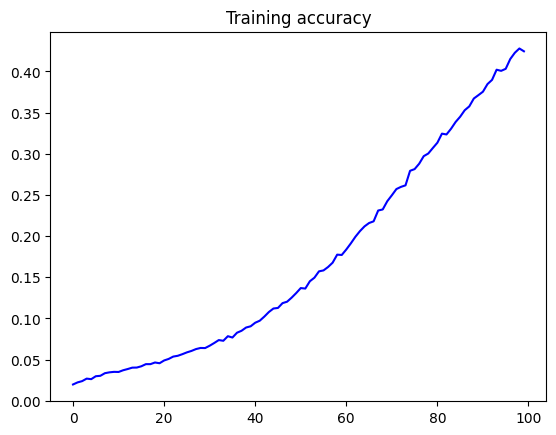

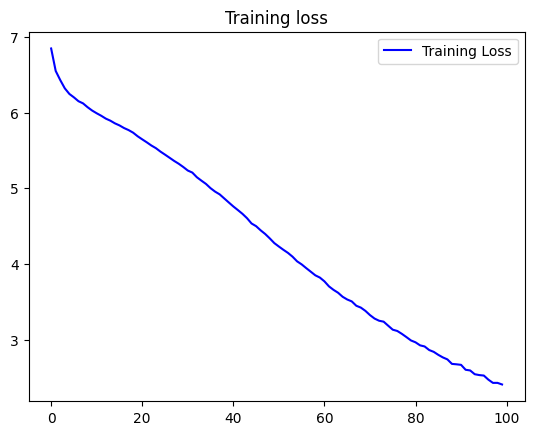

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [11]:
"""
Construye un ciclo que te permita tokenizar la frase de entrada (seed_text) y obtener
la cantidad de palabras siguientes dada por next_words

Recuerda utilizar model.predict y las funciones text to sequences y pad_sequences
"""
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0] # YOUR CODE HERE
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding = 'pre')# YOUR CODE HERE
	predicted = np.argmax(model.predict(token_list), axis=-1) # YOUR CODE HERE
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word

print(seed_text)

1/1 [==============================] - 0s 39ms/step
Help me Obi Wan Kenobi, you're my only hope not in her quiet please some beard untainted too embassage hell not dyed much hell being date sluttish praise growest shows assured confound stay of come now nor stay of have women's jacks to conspire shines so battering dost be soul were abhor my sight require shall nought so note come outworn growest spent near nor near nor nor born back then oppress'd away in date date slow partial looks oppress'd of blest day shines these buried eye new blind blind hate move things nought what be strumpeted grief's filed cured fly shines so dross groan bitter confined self store


In [12]:
# Saving model

# Saving the model's architecture
model_json = model.to_json()
with open("C6_TextGenerationModel.json", "w") as json_file:
    json_file.write(model_json) 

# Saving the model's weights
model.save_weights('C6_TextGenerationModel.h5')